### Table of contents:

* [Upload needed data](#upload)
* [Triangular matrix](#M)
* [Parameters calibration with exogenous variables](#pal_cal)
    * [Companies](#pal_cal_com)
    * [Technologies](#pal_cal_tech)
* [Rank](#rank)
    * [Companies](#rank_com)
    * [Technologies](#rank_tech)
* [Keep track of the optimal parameters and the number of iterations](#track)    
* [Quick loop](#loop)

In [193]:
import math
import arrow
import ipynb 
import os.path
import json
import pickle

import sys
import atexit
import time
import random
import operator

import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
import numpy as np

from dotenv import load_dotenv
from networkx.algorithms.bipartite.matrix import biadjacency_matrix
from networkx.algorithms import bipartite
from importlib import reload
from typing import List


In [194]:
import warnings
warnings.filterwarnings("ignore")

In [195]:
# import functions from py file 

import functions.fun
reload(functions.fun)
from functions.fun import CB_data_cleaning, df_from_api_CB, extract_nodes, extract_data_from_column
from functions.fun import nx_dip_graph_from_pandas, filter_dict, check_desc
from functions.fun import extract_classes_company_tech, degree_bip, insert_data_classes

In [196]:
# import functions from py file 

import functions.fun_meth_reflections
reload(functions.fun_meth_reflections)
from functions.fun_meth_reflections import zero_order_score, Gct_beta, Gtc_alpha, make_G_hat, next_order_score, generator_order_w
from functions.fun_meth_reflections import M_test_triangular, w_stream, find_convergence, rank_df_class, w_star_analytic

In [197]:
# import functions from py file 

import functions.fun_external_factors
reload(functions.fun_external_factors)
from functions.fun_external_factors import rank_comparison, calibrate_analytic, create_exogenous_rank

In [198]:
# import classes 

import classes
reload(classes)

<module 'classes' from '/home/anita.mezzetti/bipartite_network/classes.py'>

## Upload data <a class="anchor" id="upload"></a>

Data in the right structure are created in `create_network_dictionaries.ipynb`. In that notebook, we upload the CSV file of the data of CB, we clean the data and we create two dictionaries and a networkx graph:
- dict_companies: dictionary containing all the information about companies 
    name_company: Company
- dict_tech: dictionary containing all the information about technologies 
    name_tech: Tehcnology
- B: bipartite graph of companies and technologies

In [199]:
# imputs! 
# change them and teh rest of the code will react accordingly
# please make sure to match the num of companies with the right number of technologies

num_comp = 100
num_tech = 134

preferences_comp = {"previous_investments":0,
                    "geo_position":100}
preferences_tech = {"previous_investments":100}

flag_cybersecurity = True


In [200]:
if flag_cybersecurity==True:

    name_file_com = f'savings/classes/dict_companies_cybersecurity_{num_comp}.pickle'
    name_file_tech = f'savings/classes/dict_tech_cybersecurity_{num_tech}.pickle'
    name_file_graph = f'savings/networks/cybersecurity_comp_{num_comp}_tech_{num_tech}.gpickle'
    name_M = f'savings/M/cybersecurity_comp_{num_comp}_tech_{num_tech}.npy'

In [201]:
with open(name_file_com, 'rb') as f:
    dict_companies = pickle.load(f)
    
with open(name_file_tech, 'rb') as f:
    dict_tech = pickle.load(f)

B = nx.read_gpickle(name_file_graph)


## Triangular matrix <a class="anchor" id="M"></a>

In [202]:
set0 = extract_nodes(B, 0)
set1 = extract_nodes(B, 1)

# adjacency matrix of bipartite graph
adj_matrix = biadjacency_matrix(B, set0, set1)

In [203]:
adj_matrix_dense = adj_matrix.todense()

**Representation**

In [204]:
a = np.squeeze(np.asarray(adj_matrix_dense))
#a.sum(axis=1)

In [205]:
# M is the array version of the matrix adj_matrix_dense:
M = np.squeeze(np.asarray(adj_matrix_dense))

In [206]:
# save M in order to use it in other scripts

if flag_cybersecurity==False: # all fields
    name_file_M = 'savings/M/comp_' + str(len(dict_companies)) + '_tech_' + str(len(dict_tech)) + '.npy'                                     
else: # only companies in cybersecurity
    name_file_M = 'savings/M/cybersecurity_comp_'+ str(len(dict_companies)) + '_tech_' + str(len(dict_tech)) + '.npy'

np.save(name_file_M, M)

### Triangularize matrix

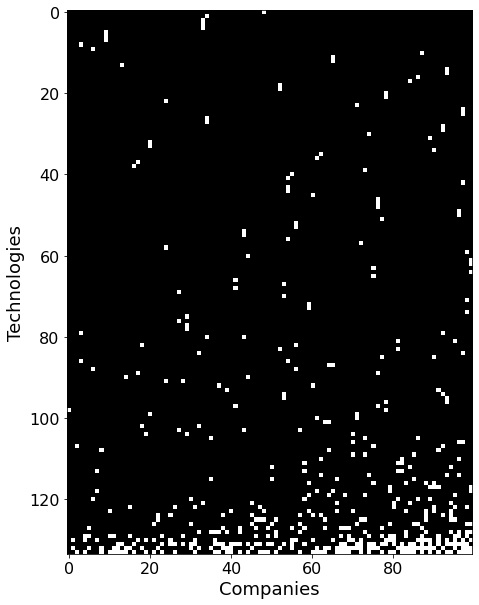

In [207]:
M_test_triangular(adj_matrix_dense, flag_cybersecurity)

## Parameters calibration with exogenous variables.  <a class="anchor" id="pal_cal"></a>

An essential step is the calibration of $\alpha$ and $\beta$, i.e. find the *optimal* parameters that maximise our correlation between model and actual. 

We decide to perform just a **grid search**, defining a way to compare our list rankings using the Spearman method from `scipy.stats`. So, we define a landscape, $[-2,2] \times [-2,2]$, and evaluate at all those points (using the analytic method). Finally we will return the top correlation we found.

NB: also for this step, we take inspiration by the work by Klein, Maillart, and Chuang.

**Companies**  <a class="anchor" id="pal_cal_com"></a>

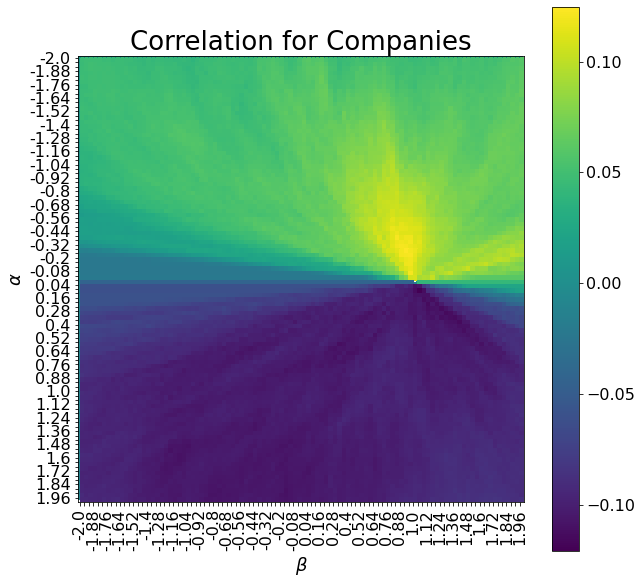

In [208]:
start_time = time.time()

best_par = calibrate_analytic(M=M,
                   ua='Companies',
                   dict_class=dict_companies, 
                   exogenous_rank=create_exogenous_rank('Companies', dict_companies, preferences_comp), 
                   index_function=lambda x: (x-50)/25,
                   title='Correlation for Companies',
                   do_plot=True,
                   preferences = preferences_comp)


end_time = time.time()

In [209]:
time_optimal_par_comp = end_time - start_time
time_optimal_par_comp

28.49213671684265

In [210]:
# highlight bets alpha and beta
optimal_alpha_comp = best_par['alpha']
optimal_beta_comp = best_par['beta']

**Technologies**  <a class="anchor" id="pal_cal_tech"></a>

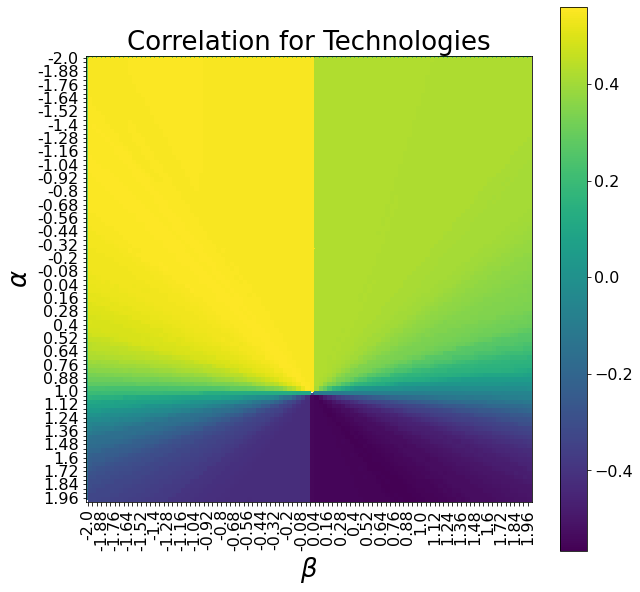

In [211]:
start_time = time.time()

best_par = calibrate_analytic(M=M,
                   ua='Technologies',
                   dict_class=dict_tech, 
                   exogenous_rank=create_exogenous_rank('Technologies', dict_tech, preferences_tech), 
                   index_function=lambda x: (x-50)/25,
                   title='Correlation for Technologies',
                   do_plot=True,
                   preferences = preferences_tech)

end_time = time.time()

In [212]:
best_par

{'spearman': 0.5598342935197115,
 'alpha': 0.96,
 'beta': -0.04,
 'ua': 'Technologies'}

In [213]:
# highlight bets alpha and beta
optimal_alpha_tech = best_par['alpha']
optimal_beta_tech = best_par['beta']

time_optimal_par_tech = end_time - start_time
time_optimal_par_tech

39.97517228126526

## Rank <a class="anchor" id="rank"></a>

### Zero order score

These are an $w_{c}$ editor-vector which is the sums of articles edited by each editor. Or the article-vector $w_{p}$, which is the sum of editors contributing to each article.

\begin{cases}
 w_{c}^{(0)} = \sum_{p=1}^{N_{p}} M \equiv k_c\\[7pt]
 w_{p}^{(0)} = \sum_{c=1}^{N_{c}} M \equiv k_p
\end{cases}

In [214]:
k_c, k_t = zero_order_score(M)

### G - transition probability function

Depending on $\alpha$ and $\beta$ we non-linearly weight based on the Zeroth order iterations. 

\begin{cases}
G_{ct}(\beta) = \frac{M_{ct} k_{c}^{-\beta}}{\sum_{c' = 1}^{N_c} M_{c't} k_{c'}^{-\beta}}\\[10pt]
G_{tc}(\alpha) = \frac{M_{ct} k_{t}^{-\alpha}}{\sum_{t' = 1}^{N_t} M_{ct'} k_{t'}^{-\alpha}}.\\\end{cases}

### Higher cases

The first order $w^{1}_c$ is the sum of the articles touched, but weighted by the Zeroth order article-vector (and the $G$ term). So if you've edited better articles that counts. And $w^{1}_c$ is the sum of editors touching, but weighted by the Zeroth order editor-vector (and $G$). So if you're touched by better editors that's also being considered. 

Beyond the first order interpretation for the higher orders is difficult.

\begin{cases}
w^{(n+1)}_c (\alpha,\beta) = \sum_{t=1}^{N_p}  G_{ct}(\beta) \,w^{(n)}_t (\alpha,\beta)\\[7pt]
w^{(n+1)}_t (\alpha,\beta) = \sum_{c=1}^{N_c}  G_{tc}(\alpha) \, w^{(n)}_c (\alpha,\beta)\\
\end{cases}

### **Companies**  <a class="anchor" id="rank_com"></a>

Converge at 101


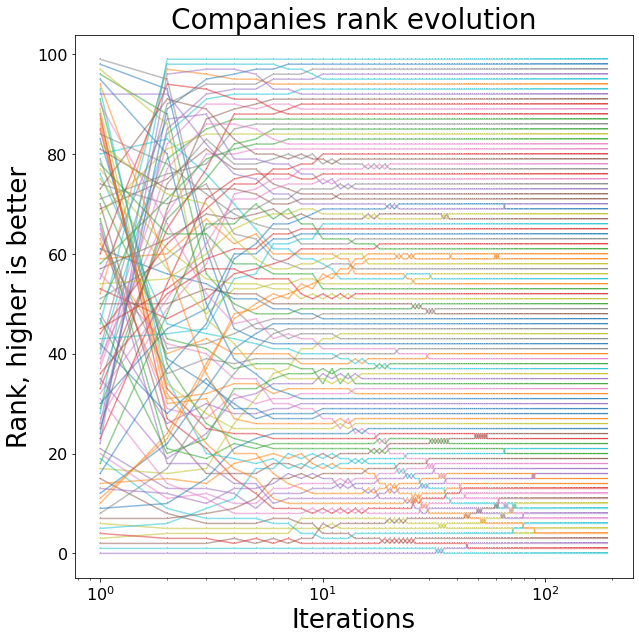

In [215]:
start_time = time.time()

convergence_comp = find_convergence(M,
                                    alpha=optimal_alpha_comp, 
                                    beta=optimal_beta_comp, 
                                    fit_or_ubiq='fitness', 
                                    do_plot=True, 
                                    flag_cybersecurity=flag_cybersecurity,
                                    preferences = preferences_comp)

end_time = time.time()

In [216]:
time_conv_comp = end_time - start_time
time_conv_comp

15.039776802062988

In [217]:
convergence_comp

{'fitness': array([4.87957496, 5.16114588, 5.82731163, 5.25085139, 3.52634495,
        5.36485981, 5.64639623, 4.6546123 , 2.61258166, 6.07343094,
        4.87805937, 4.56300383, 4.99572997, 3.9162309 , 4.3281961 ,
        5.41783559, 5.91173574, 5.52622244, 4.68718278, 5.16184479,
        4.27647393, 3.44795184, 5.78781022, 3.31687934, 6.22936819,
        2.51975109, 4.4393015 , 5.4788489 , 5.69918461, 5.3593105 ,
        4.64234456, 4.436402  , 4.45691767, 5.57351306, 4.55025809,
        3.92329723, 3.54775403, 5.17969928, 5.10699296, 4.55251562,
        4.38138683, 5.19263241, 3.8986578 , 5.96648423, 3.44920862,
        5.97087508, 5.5362835 , 5.79893644, 2.91177327, 2.76264477,
        4.20793818, 6.1114417 , 5.67480005, 5.49156715, 5.44448326,
        3.        , 5.49124605, 4.78128941, 5.16705816, 2.68919466,
        6.25694691, 2.59142385, 3.70020959, 5.1130978 , 2.76089875,
        4.90163021, 3.28187642, 4.99036024, 4.55135465, 6.6405105 ,
        5.38161175, 3.32453201, 4.554

In [218]:
df_final_companies, dict_companies = rank_df_class(convergence_comp, dict_companies)

In [219]:
# relative rank
df_final_companies['techrank_normlized'] = df_final_companies['techrank']/np.max(list(df_final_companies['techrank']))*10
n = np.max(df_final_companies['rank_CB']) + 1
df_final_companies['rank_CB_normlized'] = n - df_final_companies['rank_CB']

df_final_companies['TeckRank_int'] = df_final_companies.index + 1.0

In [220]:
df_final_companies[-10:]

,initial_position,final_configuration,degree,techrank,rank_CB,techrank_normlized,rank_CB_normlized,TeckRank_int
90,33,GoSecure,0,5.966,7594.0,8.983587,10199.0,91.0
91,25,Threatcare,0,5.971,8055.0,8.991116,9738.0,92.0
92,22,vChain,0,5.978,15265.0,9.001656,2528.0,93.0
93,40,Axis Security,0,6.073,744.0,9.144707,17049.0,94.0
94,52,Vera,0,6.111,8731.0,9.201927,9062.0,95.0
95,46,Spherical Defense,0,6.198,16273.0,9.332932,1520.0,96.0
96,26,Synack,0,6.229,3485.0,9.379612,14308.0,97.0
97,41,RunSafe Security,0,6.235,17565.0,9.388646,228.0,98.0
98,24,CybSafe,0,6.257,11175.0,9.421774,6618.0,99.0
99,28,ForAllSecure,0,6.641,12223.0,10.0,5570.0,100.0


The higher is better

In [221]:
df_final_companies

,initial_position,final_configuration,degree,techrank,rank_CB,techrank_normlized,rank_CB_normlized,TeckRank_int
0,1,Ecosystem Integrity Fund,0,2.42,17792.0,3.64403,1.0,1.0
1,4,Safepay,0,2.421,16663.0,3.645535,1130.0,2.0
2,0,Boeing,0,2.51,13199.0,3.779551,4594.0,3.0
3,15,FirstEnergy Corp.,0,2.52,3515.0,3.794609,14278.0,4.0
4,14,DRONEDEK,0,2.591,11497.0,3.901521,6296.0,5.0
...,...,...,...,...,...,...,...,...
95,46,Spherical Defense,0,6.198,16273.0,9.332932,1520.0,96.0
96,26,Synack,0,6.229,3485.0,9.379612,14308.0,97.0
97,41,RunSafe Security,0,6.235,17565.0,9.388646,228.0,98.0
98,24,CybSafe,0,6.257,11175.0,9.421774,6618.0,99.0


In [222]:
df_spearman = df_final_companies[["TeckRank_int", "rank_CB_normlized"]]
df_spearman = df_spearman.astype(float)
df_spearman["name"] = df_final_companies['final_configuration']
df_spearman.set_index("name")

,TeckRank_int,rank_CB_normlized
name,,
Ecosystem Integrity Fund,1.0,1.0
Safepay,2.0,1130.0
Boeing,3.0,4594.0
FirstEnergy Corp.,4.0,14278.0
DRONEDEK,5.0,6296.0
...,...,...
Spherical Defense,96.0,1520.0
Synack,97.0,14308.0
RunSafe Security,98.0,228.0


In [223]:
df_spearman

,TeckRank_int,rank_CB_normlized,name
0,1.0,1.0,Ecosystem Integrity Fund
1,2.0,1130.0,Safepay
2,3.0,4594.0,Boeing
3,4.0,14278.0,FirstEnergy Corp.
4,5.0,6296.0,DRONEDEK
...,...,...,...
95,96.0,1520.0,Spherical Defense
96,97.0,14308.0,Synack
97,98.0,228.0,RunSafe Security
98,99.0,6618.0,CybSafe


In [224]:
# save df
if flag_cybersecurity==False:
    name = "savings/csv_results/cybersecurity/complete_companies_" + str(len(dict_tech)) + "_" + str(preferences_tech) + ".csv"
else:
    name = "savings/csv_results/complete_companies_" + str(len(dict_tech)) + "_" + str(preferences_tech) + ".csv"

df_final_companies.to_csv(name, index = False, header=True)

**Sperman correlation**

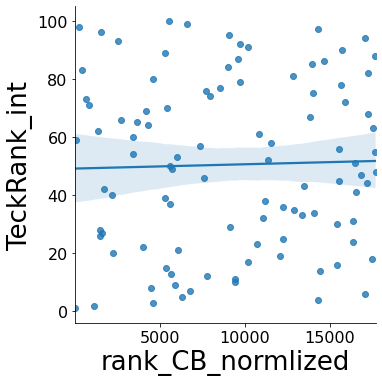

In [225]:
sns.lmplot(x="rank_CB_normlized", y="TeckRank_int", data=df_spearman)
plt.show()

In [226]:
spear_corr = df_spearman.corr(method='spearman')
spear_corr

,TeckRank_int,rank_CB_normlized
TeckRank_int,1.000000,0.026463
rank_CB_normlized,0.026463,1.000000


### **Technologies**  <a class="anchor" id="rank_tech"></a>

Converge at 721


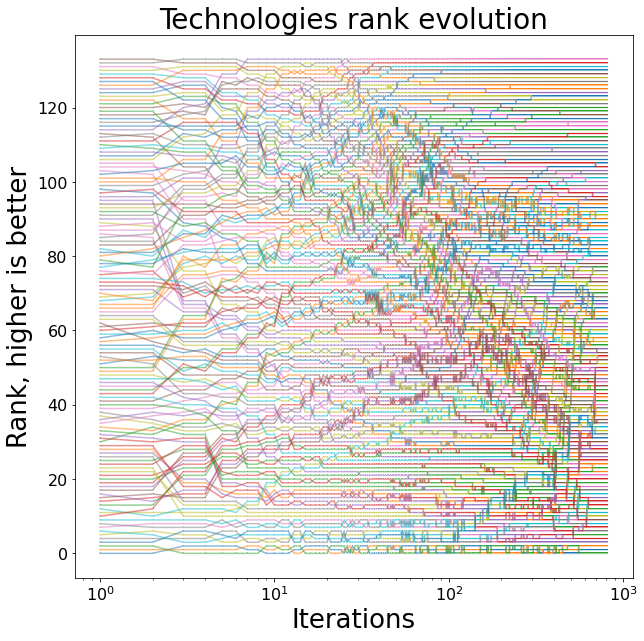

In [227]:
start_time = time.time()

convergence_tech = find_convergence(M,
                                    alpha=optimal_alpha_tech, 
                                    beta=optimal_beta_tech, 
                                    fit_or_ubiq='ubiquity', 
                                    do_plot=True, 
                                    flag_cybersecurity=flag_cybersecurity,
                                    preferences=preferences_tech)

end_time = time.time()

In [228]:
time_conv_tech = end_time - start_time
time_conv_tech

15.032928466796875

In [229]:
df_final_tech, dict_tech = rank_df_class(convergence_tech, dict_tech)
df_final_tech['TeckRank_int'] = df_final_tech.index + 1.0

In [230]:
df_final_tech

,initial_position,final_configuration,degree,techrank,TeckRank_int
0,2,Home Services,0,1.0,1.0
1,0,Home Improvement,0,1.0,2.0
2,1,Home Renovation,0,1.0,3.0
3,46,RFID,0,3.39,4.0
4,21,Digital Marketing,0,3.402,5.0
...,...,...,...,...,...
129,133,Network Security,0,3.931,130.0
130,127,Information Technology,0,3.976,131.0
131,129,Security,0,4.046,132.0
132,128,Software,0,4.053,133.0


In [231]:
# save df
if flag_cybersecurity==False:
    name = "savings/csv_results/cybersecurity/complete_tech_" + str(len(dict_tech)) + "_" + str(preferences_tech) + ".csv"
else:
    name = "savings/csv_results/complete_tech_" + str(len(dict_tech)) + "_" + str(preferences_tech) + ".csv"

df_final_tech.to_csv(name, index = False, header=True)

### Keep track of the optimal parameters and the number of iterations <a class="anchor" id="track"></a>

In a dataframe file we track the optimal parameters in each *case* (number of companies/technologies and preferences), in order to have track of everything 


In [232]:
if flag_cybersecurity==True:
    name_csv = 'savings/useful_datasets/cybersecurity_df_rank_evolu.csv'
else:
    name_csv = 'savings/useful_datasets/df_rank_evolu.csv'

df_rank_evolu = pd.read_csv(name_csv)
df_rank_evolu = df_rank_evolu.drop(['Unnamed: 0'], axis=1)
df_rank_evolu.head()

,Unnamed: 0.1,time_conv_tech,preferences_comp,number_iterations_comp,number_iterations_tech,time_conv_total,optimal_alpha_tech,num_comp,num_tech,optimal_alpha_comp,optimal_beta_comp,preferences_tech,optimal_beta_tech,time_optimal_par_comp,time_optimal_par_tech,spearman_corr_with_cb,time_conv_comp,name
0,0.0,0.727113,"{'previous_investments': 100, 'crunchbase_rank...",28,10,1.421580,-2.00,10,26,0.12,1.20,{'previous_investments': 100},0.00,10.243828,12.228126,0.018182,0.694467,"comp:10, tech:26"
1,1.0,14.338477,"{'previous_investments': 100, 'crunchbase_rank...",171,423,27.840225,0.92,100,131,0.16,1.60,{'previous_investments': 100},0.36,28.765348,35.417520,-0.324453,13.501748,"comp:100, tech:131"
2,2.0,481.560507,"{'previous_investments': 100, 'crunchbase_rank...",224,748,965.276360,0.60,500,305,0.12,1.44,{'previous_investments': 100},1.24,193.091881,160.135073,-0.267010,483.715853,"comp:500, tech:305"
3,3.0,2059.376351,"{'previous_investments': 100, 'crunchbase_rank...",386,1000,4162.843268,0.88,1000,384,0.04,1.24,{'previous_investments': 100},0.60,710.260740,319.079822,-0.240223,2103.466917,"comp:1000, tech:384"
4,4.0,1980.021571,"{'previous_investments': 100, 'crunchbase_rank...",386,2926,3966.011555,0.88,1000,384,0.04,1.24,{'previous_investments': 100},0.60,673.433667,316.865012,-0.240223,1985.989984,"comp:1000, tech:384"


In [233]:
# check if that specific case is already in the csv
if ((df_rank_evolu['num_comp'] == num_comp) &
    (df_rank_evolu['num_tech'] == num_tech) &
    (df_rank_evolu['preferences_comp'] == str(preferences_comp)) &
    (df_rank_evolu['preferences_tech'] == str(preferences_tech))
    ).any(): # present
    
    print("Already analysed")
    
    """    # find the index (sorry this part is a bit verbose):
    a = (df_rank_evolu['num_comp'] == num_comp )
    df_sel = df_rank_evolu[a]
    a = (df_sel['num_tech'] == num_tech )
    df_sel = df_sel[a]
    a = (df_sel['preferences_comp'] == preferences_comp )
    df_sel = df_sel[a]
    a = (df_sel['preferences_tech'] == preferences_tech )
    df_sel = df_sel[a]
    index = df_sel.index
    
    print(index)
    
    df_rank_evolu.loc[index, 'optimal_alpha_comp'] = optimal_alpha_comp
    df_rank_evolu.loc[index, 'optimal_beta_comp'] = optimal_beta_comp
    df_rank_evolu.loc[index, 'optimal_alpha_tech'] = optimal_alpha_tech
    df_rank_evolu.loc[index, 'optimal_beta_tech'] = optimal_beta_tech"""
    
else:
    new_row = {'num_comp': num_comp,
               'num_tech': num_tech,
                'preferences_comp': str(preferences_comp),
                'preferences_tech': str(preferences_tech),
                'optimal_alpha_comp': optimal_alpha_comp,
                'optimal_beta_comp': optimal_beta_comp,
                'optimal_alpha_tech': optimal_alpha_tech,
                'optimal_beta_tech': optimal_beta_tech,
                'number_iterations_comp': convergence_comp['iteration'],
                'number_iterations_tech': convergence_tech['iteration'],
                'time_optimal_par_comp': time_optimal_par_comp,
                'time_optimal_par_tech': time_optimal_par_tech,
                'time_conv_comp': time_conv_comp,
                'time_conv_tech': time_conv_tech,
                'time_conv_total' : time_conv_comp + time_conv_tech,
                'spearman_corr_with_cb': spear_corr['rank_CB_normlized']['TeckRank_int']
            }
    df_rank_evolu = df_rank_evolu.append(new_row, ignore_index=True)
    
 

In [234]:
df_rank_evolu.head()

,Unnamed: 0.1,time_conv_tech,preferences_comp,number_iterations_comp,number_iterations_tech,time_conv_total,optimal_alpha_tech,num_comp,num_tech,optimal_alpha_comp,optimal_beta_comp,preferences_tech,optimal_beta_tech,time_optimal_par_comp,time_optimal_par_tech,spearman_corr_with_cb,time_conv_comp,name
0,0.0,0.727113,"{'previous_investments': 100, 'crunchbase_rank...",28,10,1.421580,-2.00,10,26,0.12,1.20,{'previous_investments': 100},0.00,10.243828,12.228126,0.018182,0.694467,"comp:10, tech:26"
1,1.0,14.338477,"{'previous_investments': 100, 'crunchbase_rank...",171,423,27.840225,0.92,100,131,0.16,1.60,{'previous_investments': 100},0.36,28.765348,35.417520,-0.324453,13.501748,"comp:100, tech:131"
2,2.0,481.560507,"{'previous_investments': 100, 'crunchbase_rank...",224,748,965.276360,0.60,500,305,0.12,1.44,{'previous_investments': 100},1.24,193.091881,160.135073,-0.267010,483.715853,"comp:500, tech:305"
3,3.0,2059.376351,"{'previous_investments': 100, 'crunchbase_rank...",386,1000,4162.843268,0.88,1000,384,0.04,1.24,{'previous_investments': 100},0.60,710.260740,319.079822,-0.240223,2103.466917,"comp:1000, tech:384"
4,4.0,1980.021571,"{'previous_investments': 100, 'crunchbase_rank...",386,2926,3966.011555,0.88,1000,384,0.04,1.24,{'previous_investments': 100},0.60,673.433667,316.865012,-0.240223,1985.989984,"comp:1000, tech:384"


In [235]:
# save 
df_rank_evolu.to_csv(name_csv)

## Quick loop  <a class="anchor" id="loop"></a>

With quick loop, we mean that we do all the step of the previous sections, in order to update the dictionaries, for all size, in only one loop.

In this part, you won't see many comments because everything has been already explained before :)

In [236]:
size_comp = [10, 100, 500, 1000, 1499, 1999, 2442]
size_tech = [26, 131, 305, 384, 431, 456, 478]

flag_cybersecurity = False

preferences_comp = {"previous_investments":100,
                    "crunchbase_rank":0}
preferences_tech = {"previous_investments":100}

In [238]:
for i in range(len(size_comp[:2])):
    num_comp = size_comp[i]
    num_tech = size_tech[i]
    
    print(f'\n num comp:{num_comp}, num tech: {num_tech}')
    
    name_file_com = f'savings/classes/dict_companies_cybersecurity_{num_comp}.pickle'
    name_file_tech = f'savings/classes/dict_tech_cybersecurity_{num_tech}.pickle'
    name_file_graph = f'savings/networks/cybersecurity_comp_{num_comp}_tech_{num_tech}.gpickle'
    name_M = f'savings/M/cybersecurity_comp_{num_comp}_tech_{num_tech}.npy'
    flag_cybersecurity = True

    with open(name_file_com, 'rb') as f:
        dict_companies = pickle.load(f)

    with open(name_file_tech, 'rb') as f:
        dict_tech = pickle.load(f)

    B = nx.read_gpickle(name_file_graph)

    set0 = extract_nodes(B, 0)
    set1 = extract_nodes(B, 1)

    # adjacency matrix of bipartite graph
    adj_matrix = biadjacency_matrix(B, set0, set1)
    adj_matrix_dense = adj_matrix.todense()

    a = np.squeeze(np.asarray(adj_matrix_dense))
    M = np.squeeze(np.asarray(adj_matrix_dense))

    if flag_cybersecurity==False: # all fields
        name_file_M = 'savings/M/comp_' + str(len(dict_companies)) + '_tech_' + str(len(dict_tech)) + '.npy'                                     
    else: # only companies in cybersecurity
        name_file_M = 'savings/M/cybersecurity_comp_'+ str(len(dict_companies)) + '_tech_' + str(len(dict_tech)) + '.npy'

    np.save(name_file_M, M)

    M_test_triangular(adj_matrix_dense, flag_cybersecurity)

    #par opt
    start_time = time.time()
    best_par = calibrate_analytic(M=M,
                       ua='Companies',
                       dict_class=dict_companies, 
                       exogenous_rank=create_exogenous_rank('Companies', dict_companies, preferences_comp), 
                       index_function=lambda x: (x-50)/25,
                       title='Correlation for Companies',
                       do_plot=True,
                       preferences = preferences_comp)
    end_time = time.time()
    time_optimal_par_comp = end_time - start_time
    optimal_alpha_comp = best_par['alpha']
    optimal_beta_comp = best_par['beta']

    start_time = time.time()
    best_par = calibrate_analytic(M=M,
                       ua='Technologies',
                       dict_class=dict_tech, 
                       exogenous_rank=create_exogenous_rank('Technologies', dict_tech, preferences_tech), 
                       index_function=lambda x: (x-50)/25,
                       title='Correlation for Companies',
                       do_plot=True,
                       preferences = preferences_tech)
    end_time = time.time()
    optimal_alpha_tech = best_par['alpha']
    optimal_beta_tech = best_par['beta']
    time_optimal_par_tech = end_time - start_time

    k_c, k_t = zero_order_score(M)

    start_time = time.time()
    convergence_comp = find_convergence(M,
                                        alpha=optimal_alpha_comp, 
                                        beta=optimal_beta_comp, 
                                        fit_or_ubiq='fitness', 
                                        do_plot=True, 
                                        flag_cybersecurity=flag_cybersecurity,
                                        preferences = preferences_comp)
    end_time = time.time()

    df_final_companies, dict_companies = rank_df_class(convergence_comp, dict_companies)
    df_final_companies['techrank_normlized'] = df_final_companies['techrank']/np.max(list(df_final_companies['techrank']))*10
    n = np.max(df_final_companies['rank_CB']) + 1
    df_final_companies['rank_CB_normlized'] = n - df_final_companies['rank_CB']
    df_final_companies['TeckRank_int'] = df_final_companies.index + 1.0
    df_spearman = df_final_companies[["TeckRank_int", "rank_CB_normlized"]]
    df_spearman = df_spearman.astype(float)
    df_spearman["name"] = df_final_companies['final_configuration']
    df_spearman.set_index("name")
    name = "savings/csv_results/complete_companies_" + str(len(dict_companies)) + "_" + str(preferences_comp) + ".csv"
    df_final_companies.to_csv(name, index = False, header=True)

    spear_corr = df_spearman.corr(method='spearman')

    start_time = time.time()
    convergence_tech = find_convergence(M,
                                        alpha=optimal_alpha_tech, 
                                        beta=optimal_beta_tech, 
                                        fit_or_ubiq='ubiquity', 
                                        do_plot=True, 
                                        flag_cybersecurity=flag_cybersecurity,
                                        preferences=preferences_tech)
    end_time = time.time()
    time_conv_tech = end_time - start_time
    df_final_tech, dict_tech = rank_df_class(convergence_tech, dict_tech)
    df_final_tech['TeckRank_int'] = df_final_tech.index + 1.0
    name = "savings/csv_results/complete_tech_" + str(len(dict_tech)) + "_" + str(preferences_tech) + ".csv"
    df_final_tech.to_csv(name, index = False, header=True)

    if flag_cybersecurity==True:
        name_csv = 'savings/useful_datasets/cybersecurity_df_rank_evolu.csv'
    else:
        name_csv = 'savings/useful_datasets/df_rank_evolu.csv'
    
    df_rank_evolu = pd.read_csv(name_csv)
    
    df_rank_evolu = df_rank_evolu.drop(['Unnamed: 0'], axis=1)
    # check if that specific case is already in the csv
    if ((df_rank_evolu['num_comp'] == num_comp) &
        (df_rank_evolu['num_tech'] == num_tech) &
        (df_rank_evolu['preferences_comp'] == str(preferences_comp)) &
        (df_rank_evolu['preferences_tech'] == str(preferences_tech))
        ).any(): # present

        print("Already analysed")

    else:
        new_row = {'num_comp': num_comp,
                   'num_tech': num_tech,
                    'preferences_comp': str(preferences_comp),
                    'preferences_tech': str(preferences_tech),
                    'optimal_alpha_comp': optimal_alpha_comp,
                    'optimal_beta_comp': optimal_beta_comp,
                    'optimal_alpha_tech': optimal_alpha_tech,
                    'optimal_beta_tech': optimal_beta_tech,
                    'number_iterations_comp': convergence_comp['iteration'],
                    'number_iterations_tech': convergence_tech['iteration'],
                    'time_optimal_par_comp': time_optimal_par_comp,
                    'time_optimal_par_tech': time_optimal_par_tech,
                    'time_conv_comp': time_conv_comp,
                    'time_conv_tech': time_conv_tech,
                    'time_conv_total' : time_conv_comp + time_conv_tech,
                    'spearman_corr_with_cb': spear_corr['rank_CB_normlized']['TeckRank_int']
                }
        df_rank_evolu = df_rank_evolu.append(new_row, ignore_index=True)
    
     df_rank_evolu.to_csv(name_csv)

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 147)